In [17]:
import os

DATA_FOLDER = os.path.abspath(os.path.join('..', 'data'))
FIGURE_FOLDER = os.path.abspath(os.path.join('..', 'figures'))
MODEL_FOLDER = os.path.abspath(os.path.join('..', 'models'))

notebook_name = '051_run_pep_keras_genomics'

data_folder = os.path.join(DATA_FOLDER, notebook_name)
figure_folder = os.path.join(FIGURE_FOLDER, notebook_name)
model_folder = os.path.join(MODEL_FOLDER, notebook_name)

! mkdir -p $data_folder
! mkdir -p $figure_folder
! mkdir -p $model_folder

model = os.path.join(model_folder, 'model.py')

input_folder = os.path.join(DATA_FOLDER, '023_make_train_valid_test_sets')

In [10]:
ls $DATA_FOLDER/001_amino_acid_encoding

molecular_weight.csv  side_chain_charge.csv  side_chain_polarity.csv
one_hot_encoding.csv  side_chain_class.csv


In [1]:
# from tensorflow.python.client import device_lib ; print(device_lib.list_local_devices())

### Keras-genomics wants mapping files that are tab-separated and have no headers

In [13]:
import glob
import pandas as pd

encoding_folder = os.path.join(DATA_FOLDER, '001_amino_acid_encoding')

for csv in glob.glob(os.path.join(encoding_folder, '*.csv')):
    basename = os.path.basename(csv)
    tsv = os.path.join(data_folder, basename.replace('csv', 'tsv'))
    df = pd.read_csv(csv)
    df.to_csv(tsv, sep='\t', header=False, index=False)
! head $data_folder/*tsv

==> /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/molecular_weight.tsv <==
A	89.094
C	121.154
D	133.10399999999998
E	147.131
F	165.192
G	75.067
H	155.156
I	131.175
K	146.189
L	131.175

==> /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/one_hot_encoding.tsv <==
A	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
C	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
D	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
E	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
F	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
G	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
H	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
I	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0
K	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0
L	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0

==> /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/side_chain_charge.tsv <==
A	0	1.0	0.0
C	0	1.0	0.0
D	1	0.0	0.0
E	1	0.0	0.0
F	0	1.0	0.0
G	0	1.0	0.0
H	0	0.9	0.1
I	0	1.0	0.0
K	0	0.0	1.0
L	0	1.0	0.0

==> /sr

In [18]:
%%file $model
"""
function (and parameter space) definitions for hyperband
binary classification with Keras (multilayer perceptron)
"""

from __future__ import print_function
from pprint import pprint

from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from keras.callbacks import EarlyStopping
from keras.layers import GlobalMaxPooling2D
from keras.layers.advanced_activations import *
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adadelta

from common_defs import *

# a dict with x_train, y_train, x_test, y_test

space = {
    'DROPOUT': hp.choice('drop', (0.1, 0.5, 0.75)),
    'DELTA': hp.choice('delta', (1e-04, 1e-06, 1e-08)),
    'MOMENT': hp.choice('moment', (0.9, 0.99, 0.999)),
}


def get_params():
    params = sample(space)
    return handle_integers(params)


def print_params(params):
    pprint({k: v for k, v in params.items() if not k.startswith('layer_')})
    print()


def try_params(n_iterations, params, data=None, datamode='memory'):
    print("iterations:", n_iterations)
    print_params(params)

    batchsize = 100
    if datamode == 'memory':
        X_train, Y_train = data['train']
        X_valid, Y_valid = data['valid']
        inputshape = X_train.shape[1:]
    else:
        train_generator = data['train']['gen_func'](batchsize,
                                                    data['train']['path'])
        valid_generator = data['valid']['gen_func'](batchsize,
                                                    data['valid']['path'])
        train_epoch_step = data['train']['n_sample'] / batchsize
        valid_epoch_step = data['valid']['n_sample'] / batchsize
        inputshape = \
        data['train']['gen_func'](batchsize, data['train']['path']).next()[
            0].shape[1:]

    model = Sequential()
    model.add(Conv2D(128, (1, 8), padding='same', input_shape=inputshape,
                     activation='relu'))
    model.add(GlobalMaxPooling2D())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(params['DROPOUT']))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    optim = Adadelta
    myoptimizer = optim(epsilon=params['DELTA'], rho=params['MOMENT'])
    mylossfunc = 'categorical_crossentropy'
    model.compile(loss=mylossfunc, optimizer=myoptimizer, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

    if datamode == 'memory':
        model.fit(
            X_train,
            Y_train,
            batch_size=batchsize,
            epochs=int(round(n_iterations)),
            validation_data=(X_valid, Y_valid),
            callbacks=[early_stopping])
        score, acc = model.evaluate(X_valid, Y_valid)
    else:
        model.fit_generator(
            train_generator,
            steps_per_epoch=train_epoch_step,
            epochs=int(round(n_iterations)),
            validation_data=valid_generator,
            validation_steps=valid_epoch_step,
            callbacks=[early_stopping])
        score, acc = model.evaluate_generator(valid_generator,
                                              steps=valid_epoch_step)

    return {'loss': score, 'model': (
    model.to_json(), optim, myoptimizer.get_config(), mylossfunc)}


Writing /src/myhome/code/sequence-localization/models/051_run_pep_keras_genomics/model.py


In [23]:
import glob


mapperfiles = glob.glob(os.path.join(data_folder, '*tsv'))

dtypes = 'train', 'valid', 'test'
keras_genomics = '/src/myhome/code/Keras-genomics'

seqdata_prefix = 'Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150'

model = os.path.join(model_folder, 'model.py')

for i, mapperfile in enumerate(mapperfiles):
    expt_n = str(i).zfill(2)
#     print(expt_n)
    mapper_prefix = os.path.basename(mapperfile).split('.tsv')[0]
    expt_dir = os.path.join(data_folder, f'pep_expt{expt_n}_{mapper_prefix}')
    print(expt_dir)
    for dtype in dtypes:
        print(f"--- Making {dtype} dataset ... ---")
        input_data = os.path.join(input_folder, f'{seqdata_prefix}.{dtype}')
        target = os.path.join(input_folder, f'{seqdata_prefix}.target.tsv.{dtype}')
        output = os.path.join(expt_dir, f'{dtype}.h5')
        ! python $keras_genomics/embedH5.py --mapperfile $mapperfile $input_data $target $output
    # Run the model
    ! python $keras_genomics/main.py -d $expt_dir -m $model -y -t -e --trainepoch 50

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt00_side_chain_charge
--- Making train dataset ... ---
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
args: Namespace(batch=5000, dataname='data', infile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.train', infile2='', isseq='Y', labelfile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.target.tsv.train', labelname='label', maniprefix='/data', mapperfile='/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/side_chain_charge.tsv', outfile='/src/myhome/code/seq

6300/6300 [==============================] - 1s 147us/step - loss: 0.6912 - acc: 0.6143 - val_loss: 0.6758 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 59us/step

2 seconds.

3 | Wed May 30 21:25:18 2018 | lowest loss so far: 0.6753 (run 2)

iterations: 2.2222222222222223
{'DELTA': 0.0001, 'DROPOUT': 0.1, 'MOMENT': 0.99}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 158us/step - loss: 0.7919 - acc: 0.6117 - val_loss: 0.6753 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 49us/step

2 seconds.

4 | Wed May 30 21:25:20 2018 | lowest loss so far: 0.6753 (run 2)

iterations: 2.2222222222222223
{'DELTA': 0.0001, 'DROPOUT': 0.1, 'MOMENT': 0.99}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 161us/step - loss: 0.7327 - acc: 0.6098 - val_loss: 0.6760 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 235us/step - loss: 0.6790 - acc: 0.6098 - val_loss: 0.6753 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 67us/step - loss: 0.6722 - acc: 0.6194 - val_loss: 0.6753 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 67us/step - loss: 0.6714 - acc: 0.6202 - val_loss: 0.6747 - val_acc: 0.5944
Epoch 4/7
6300/6300 [==============================] - 0s 67us/step - loss: 0.6670 - acc: 0.6198 - val_loss: 0.6746 - val_acc: 0.5944
Epoch 5/7
6300/6300 [==============================] - 0s 69us/step - loss: 0.6655 - acc: 0.6190 - val_loss: 0.6746 - val_acc: 0.5944
Epoch 6/7
6300/6300 [==============================] - 0s 66us/step - loss: 0.6642 - acc: 0.6197 - val_loss: 0.6748 - val_acc: 0.5944
Epoch 7/7
900/900 [==============================] - 0s 68us/step

5 seconds.

15 | Wed May 30 21:25:54 2018 | lowest loss so far: 0.6742 (run 14)



6300/6300 [==============================] - 0s 67us/step - loss: 0.6498 - categorical_accuracy: 0.6214 - val_loss: 0.6766 - val_categorical_accuracy: 0.5944

Epoch 00015: val_loss did not improve from 0.67386
Epoch 16/50
6300/6300 [==============================] - 0s 70us/step - loss: 0.6481 - categorical_accuracy: 0.6211 - val_loss: 0.6792 - val_categorical_accuracy: 0.5944

Epoch 00016: val_loss did not improve from 0.67386
Epoch 17/50
6300/6300 [==============================] - 0s 64us/step - loss: 0.6422 - categorical_accuracy: 0.6240 - val_loss: 0.6798 - val_categorical_accuracy: 0.5944

Epoch 00017: val_loss did not improve from 0.67386
Test AUC for output neuron 0: 0.5001237681808943
Test categorical accuracy: 0.6144444444444445
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt01_molecular_weight
--- Making train dataset ... ---
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdt

6300/6300 [==============================] - 5s 868us/step - loss: 6.1718 - acc: 0.6127 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 50us/step

6 seconds.

2 | Wed May 30 21:26:35 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 2.2222222222222223
{'DELTA': 0.0001, 'DROPOUT': 0.1, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 137us/step - loss: 6.1613 - acc: 0.6176 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 43us/step

2 seconds.

3 | Wed May 30 21:26:37 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 2.2222222222222223
{'DELTA': 1e-06, 'DROPOUT': 0.1, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 130us/step - loss: 9.7391 - acc: 0.3952 - val_loss: 9.5813 - val_acc: 0.4056
Epoch 2/2
900/900 [==============================] - 0s 55

6300/6300 [==============================] - 0s 65us/step - loss: 6.1075 - acc: 0.6189 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 62us/step - loss: 6.1095 - acc: 0.6197 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 4/7
900/900 [==============================] - 0s 66us/step

4 seconds.

15 | Wed May 30 21:27:09 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 6.666666666666666
{'DELTA': 1e-08, 'DROPOUT': 0.5, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 2s 243us/step - loss: 4.2268 - acc: 0.5635 - val_loss: 0.7133 - val_acc: 0.5544
Epoch 2/7
6300/6300 [==============================] - 0s 66us/step - loss: 0.7000 - acc: 0.6125 - val_loss: 0.6923 - val_acc: 0.5889
Epoch 3/7
6300/6300 [==============================] - 0s 65us/step - loss: 0.6866 - acc: 0.6184 - val_loss: 0.6870 - val_acc: 0.5944
Epoch 4/7
6300/6300 [==============================] - 0s 65us/ste

batch_array.shape - before slicing (5000,)
batch_array.shape - after slicing (900,)
target.shape (900, 2)
seqs.shape (900, 2)
data shape:  (900, 4, 1, 150)
--- Making test dataset ... ---
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
args: Namespace(batch=5000, dataname='data', infile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.test', infile2='', isseq='Y', labelfile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.target.tsv.test', labelname='label', maniprefix='/data', mapperfile='/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/

900/900 [==============================] - 0s 63us/step

2 seconds.

7 | Wed May 30 21:27:58 2018 | lowest loss so far: 0.6741 (run 1)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.1, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 173us/step - loss: 0.6725 - acc: 0.6167 - val_loss: 0.6861 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 62us/step

2 seconds.

8 | Wed May 30 21:28:00 2018 | lowest loss so far: 0.6741 (run 1)

iterations: 2.2222222222222223
{'DELTA': 0.0001, 'DROPOUT': 0.75, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 191us/step - loss: 0.7329 - acc: 0.6154 - val_loss: 0.6818 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 64us/step

2 seconds.

9 | Wed May 30 21:28:03 2018 | lowest loss so far: 0.6741 (run 1)

iterations: 2.2222222222222223
{'DELTA': 1

6300/6300 [==============================] - 0s 66us/step - loss: 0.6553 - acc: 0.6187 - val_loss: 0.6746 - val_acc: 0.5944
Epoch 6/7
6300/6300 [==============================] - 0s 68us/step - loss: 0.6510 - acc: 0.6165 - val_loss: 0.6745 - val_acc: 0.5944
Epoch 7/7
900/900 [==============================] - 0s 69us/step

5 seconds.

17 | Wed May 30 21:28:33 2018 | lowest loss so far: 0.6737 (run 9)

iterations: 6.666666666666666
{'DELTA': 0.0001, 'DROPOUT': 0.1, 'MOMENT': 0.99}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 2s 258us/step - loss: 0.6953 - acc: 0.6040 - val_loss: 0.6768 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 68us/step - loss: 0.6637 - acc: 0.6200 - val_loss: 0.6814 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 70us/step - loss: 0.6606 - acc: 0.6200 - val_loss: 0.6785 - val_acc: 0.5944
Epoch 4/7
900/900 [==============================] - 0s 71us/ste

data shape:  (1800, 22, 1, 150)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch1 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch2 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/valid.h5.batch1 ...

*** 9 configurations x 2.2 iterations each

1 | Wed May 30 21:29:01 2018 | lowest loss so far: inf (run -1)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.5, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
2018-05-

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 201us/step - loss: 0.6702 - acc: 0.6140 - val_loss: 0.6739 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 79us/step

3 seconds.

*** 3.0 configurations x 6.7 iterations each

10 | Wed May 30 21:29:27 2018 | lowest loss so far: 0.6742 (run 3)

iterations: 6.666666666666667
{'DELTA': 1e-06, 'DROPOUT': 0.1, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 217us/step - loss: 0.6693 - acc: 0.6144 - val_loss: 0.6761 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 1s 81us/step - loss: 0.6607 - acc: 0.6200 - val_loss: 0.6799 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 1s 86us/step - loss: 0.6555 - acc: 0.6176 - val_loss: 0.6794 - val_acc: 0.5922
Epoch 4/7
900/900 [==============================] - 0s 79us/step

4 seconds.

11 | Wed May 30

6300/6300 [==============================] - 1s 85us/step - loss: 0.6650 - acc: 0.6200 - val_loss: 0.6785 - val_acc: 0.5944
Epoch 4/7
900/900 [==============================] - 0s 86us/step

4 seconds.
{'DELTA': 1e-06, 'DROPOUT': 0.1, 'MOMENT': 0.999}
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch1 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch2 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/valid.h5.batch1 ...
Train on 6300 samples, validate on 900 samples
Epoch 1/50
6300/6300 [==============================] - 2s 303us/step - loss: 0.6704 - categorical_accuracy: 0.6132 - val_loss: 0.6778 - val_categorical_accuracy: 0.5944

Epoch 00001: val_loss improved from inf to 0.67779, saving model to /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03

batch_array.shape - before slicing (5000,)
batch_array.shape - after slicing (1800,)
target.shape (1800, 2)
seqs.shape (1800, 2)
data shape:  (1800, 10, 1, 150)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class/train.h5.batch1 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class/train.h5.batch2 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class/valid.h5.batch1 ...

*** 9 configurations x 2.2 iterations each

1 | Wed May 30 21:30:31 2018 | lowest loss so far: inf (run -1)

iterations: 2.2222

900/900 [==============================] - 0s 64us/step

2 seconds.

9 | Wed May 30 21:30:53 2018 | lowest loss so far: 0.6746 (run 1)

iterations: 2.2222222222222223
{'DELTA': 0.0001, 'DROPOUT': 0.75, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 190us/step - loss: 0.6741 - acc: 0.6146 - val_loss: 0.6763 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 65us/step

2 seconds.

*** 3.0 configurations x 6.7 iterations each

10 | Wed May 30 21:30:56 2018 | lowest loss so far: 0.6746 (run 1)

iterations: 6.666666666666667
{'DELTA': 0.0001, 'DROPOUT': 0.1, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 212us/step - loss: 0.6825 - acc: 0.6105 - val_loss: 0.6757 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 70us/step - loss: 0.6640 - acc: 0.6200 - val_loss: 0.6752 - val_acc: 0.5944
Epoch 3/7
6

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 2s 250us/step - loss: 0.6743 - acc: 0.6116 - val_loss: 0.6762 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 73us/step - loss: 0.6643 - acc: 0.6200 - val_loss: 0.6751 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 77us/step - loss: 0.6649 - acc: 0.6194 - val_loss: 0.6757 - val_acc: 0.5944
Epoch 4/7
6300/6300 [==============================] - 0s 77us/step - loss: 0.6643 - acc: 0.6203 - val_loss: 0.6756 - val_acc: 0.5944
Epoch 5/7
6300/6300 [==============================] - 0s 71us/step - loss: 0.6631 - acc: 0.6195 - val_loss: 0.6745 - val_acc: 0.5944
Epoch 6/7
6300/6300 [==============================] - 0s 75us/step - loss: 0.6623 - acc: 0.6192 - val_loss: 0.6761 - val_acc: 0.5944
Epoch 7/7
900/900 [==============================] - 0s 79us/step

5 seconds.
{'DELTA': 1e-06, 'DROPOUT': 0.75, 'MOMENT': 0.999}
Reading /src/myhome

In [24]:
! ls $data_folder/*expt*

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt00_side_chain_charge:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt01_molecular_weight:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt02_side_chain_polarity:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class:
model		test.txt	 train.h5.batch2  valid.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

experiments = glob.glob(os.path.join(data_folder, '*expt*'))

dfs = []

for experiment in experiments:

    txt = os.path.join(experiment, 'model', 'model.training_history.txt')
    ! ls $txt
    df = pd.read_table(txt)
    df.columns = df.columns.str.strip('# ')
    print(df.shape)
    df.head()

    reset_index = df.reset_index()
    reset_index = reset_index.rename(columns={'index': 'epoch'})
    reset_index.head()

    tidy = pd.melt(reset_index, id_vars='epoch')
    print(tidy.shape)
    tidy.head()
    
    amino_acid_encoding = '_'.join(os.path.basename(experiment).split('_')[2:])
    print(f'amino_acid_encoding: {amino_acid_encoding}')
    
    tidy['amino_acid_encoding'] = amino_acid_encoding
    dfs.append(tidy)
training_history = pd.concat(dfs, ignore_index=True)

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/model/model.training_history.txt
(16, 4)
(64, 3)
amino_acid_encoding: one_hot_encoding
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt02_side_chain_polarity/model/model.training_history.txt
(12, 4)
(48, 3)
amino_acid_encoding: side_chain_polarity
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt01_molecular_weight/model/model.training_history.txt
(11, 4)
(44, 3)
amino_acid_encoding: molecular_weight
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt00_side_chain_charge/model/model.training_history.txt
(17, 4)
(68, 3)
amino_acid_encoding: side_chain_charge
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class/model/model.training_history.txt
(18, 4)
(72, 3)
amino_acid_encoding: side_chain_class


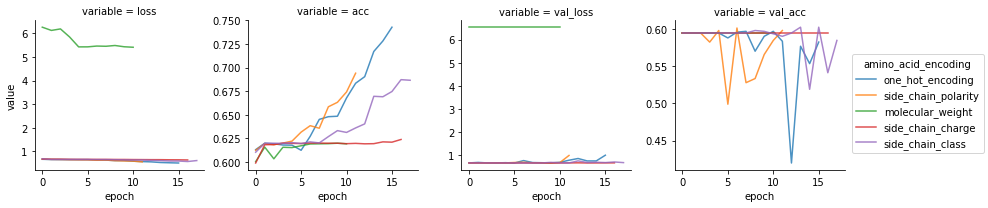

In [29]:
g = sns.FacetGrid(data=training_history, col='variable', hue='amino_acid_encoding', sharey=False)
g.map(plt.plot, 'epoch', 'value', alpha=0.8)
# g.set(ylim=(.4, 1), xlim=(0, 20))
g.add_legend()

svg = os.path.join(figure_folder, 'training_history.svg')
g.savefig(svg)

png = os.path.join(figure_folder, 'training_history.png')
g.savefig(png, dpi=300)

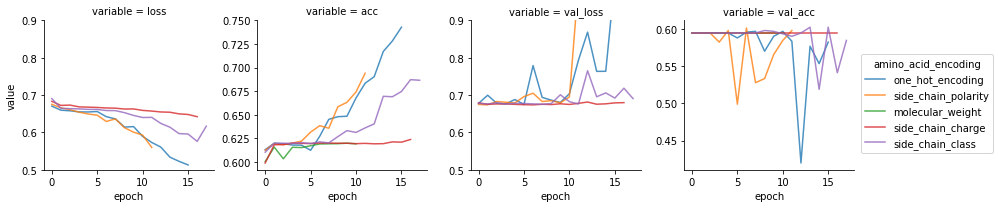

In [30]:
g = sns.FacetGrid(data=training_history, col='variable', hue='amino_acid_encoding', sharey=False)
g.map(plt.plot, 'epoch', 'value', alpha=0.8)
# g.set(ylim=(.4, 1), xlim=(0, 20))
for ax in g.axes.flat:
    if 'loss' in ax.get_title():
        ax.set(ylim=(.5, .9))
g.add_legend()
        
svg = os.path.join(figure_folder, 'training_history_zoom_loss.svg')
g.savefig(svg)

png = os.path.join(figure_folder, 'training_history_zoom_loss.png')
g.savefig(png, dpi=300)

In [12]:
ax.get_title() 

'variable = val_acc'

In [21]:
import math

In [22]:
math.factorial(5)

120